# Notebook for running all the network at one place

## Initialization and Data Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame, Series
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Tuple,
    Type,
    Union,
    no_type_check,
)
from util import ensure_dir
from datetime import date
import xarray as xr
import seaborn as sns

sns.set_theme(style="whitegrid")

In [3]:
from qids_lib import QIDS

# dataset = Dataset.load('../../data/parsed') # Deprecated
qids = QIDS(path_prefix='../../')

In [4]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc/fundamental_v0.nc')
ds = base_ds.merge(market_brief_ds).merge(fundamental_v0_ds)

In [5]:
ds_extend = ds.assign(day_feature=('day', ds['day'].data), asset_name=('asset', ds['asset'].data))

In [6]:
ds.dims

Frozen({'day': 1000, 'asset': 54, 'timeslot': 50})

In [7]:
ds  # examine the new format of the data

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/29)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    earnings           (day, asset) float64 ...
    book               (day, asset) float64 ...
    sales              (day, asset) float64 ...
    cashflow           (day, asset) float64 ...
    market_cap         (asset, day) float64 ...
    market_share       (asset) float64 ...

In [8]:
ds_extend

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/31)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    sales              (day, asset) float64 ...
    cashflow           (day, asset) float64 ...
    market_cap         (asset, day) float64 ...
    market_share       (asset) float64 ...
    day_feature        (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
    asset_name         (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53

## Neural Network Model

In [20]:
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

IS_CUDA = torch.cuda.is_available()
IS_CUDA

False

### MLP

In [11]:
class MLP(nn.Module):  # type1 - fully connected layers
    def __init__(self, D_out, input_shape, is_cuda: bool = True):
        # D_in - dimension of input channel, should be 3 for point cloud coordinates
        # D_out - number of classes label
        # k - number of rays
        # N - number of points on one ray
        super(MLP, self).__init__()
        # self.fc1 = nn.Linear(input_shape[1]*input_shape[2], 1024)
        # self.fc2 = nn.Linear(1024, 256)
        # self.fc3 = nn.Linear(256, 64)
        # self.fc4 = nn.Linear(64, D_out)
        # self.dropout = nn.Dropout(p=0.2)
        # self.bn1 = nn.BatchNorm1d(1024)
        # self.bn2 = nn.BatchNorm1d(256)
        # self.bn3 = nn.BatchNorm1d(64)
        # self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_shape[1] * input_shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, D_out)
        self.dropout = nn.Dropout(p=0.2)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()

        self.is_cuda = is_cuda
        if self.is_cuda:
            self.cuda()
        else:
            self.cpu()

    #         self.final_layer = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.contiguous().view(-1, self.num_flat_features(x))
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.dropout(self.fc3(x))))
        x = self.fc4(x)
        #         x = self.final_layer(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


### LSTM

In [12]:
class LSTM(nn.Module):

    def __init__(self, num_output, num_features,
                 hidden_size, num_layers, is_cuda: bool = False):
        ## hidden_size is like embedding feature space dimension
        ## better > num_assets?
        ## if num_layers = 2: stack 2 LSTM of lyaer 1:
        # nn.Sequential(OrderedDict([
        #     ('LSTM1', nn.LSTM(input_size, hidden_size, 1),
        #     ('LSTM2', nn.LSTM(hidden_size, hidden_size, 1)
        #     ]))
        super(LSTM, self).__init__()
        self.num_output = num_output
        self.num_layers = num_layers
        self.num_features = num_features
        self.hidden_size = hidden_size
        # self.window_size = window_size
        ## LSTM input size (batch_first) (batch, seq_length, feature)
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, num_output)

        self.is_cuda = is_cuda

        if is_cuda:
            # self.lstm.cuda()
            # self.dropout.cuda()
            # self.fc.cuda()
            self.cuda()
        else:
            self.cpu()

    def forward(self, x: torch.Tensor):
        # print(x.shape)
        batch_size = x.shape[0]
        # the second dim for h_0 and c_0 is the batch dim
        # hidden state
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)
        # cell state
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)

        if self.is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        # print(x.device)
        # print(list(x.device for x in self.lstm.parameters()))
        # print(h_0.device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # get only the last hidden layer, needed for multiple layer
        h_out = h_out[-1, :, :].view(-1, self.hidden_size)

        out = self.fc(self.dropout(h_out))

        return out


### One Dimensional Convolution Network

In [13]:
class oneDVerConvNet(nn.Module):  # type3 - 1D Vertical Convolution
    def __init__(self, D_in, D_out, input_shape, b_size, is_cuda):
        # input_shape: without batch dimension
        # b_size: batch size
        super(oneDVerConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(D_in, 16, (3, 1), stride=(1, 1), padding=(1, 0)),
            # nn.BatchNorm2d(16), # no batch
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 1024, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            # nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.drop_out = nn.Dropout(p=0.2)
        n_size = self._get_conv_output(input_shape, b_size)
        # print(n_size)
        # Treating each feature as the column
        self.fc1 = nn.Linear(n_size, 256)
        # self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, D_out)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)

        ## One entry transform; Treating each stock as the column
        # self.transform1 = nn.Conv2d(n_size, 256, kernel_size = (1,1), stride = (1,1), padding=0)
        # self.transform2 = nn.Conv2d(256, 64, kernel_size = (1,1), stride = (1,1), padding=0)
        # self.transform3 = nn.Conv2d(64, D_out, kernel_size = (1,1), stride = (1,1), padding=0)

        self.is_cuda = is_cuda
        if self.is_cuda:
            self.cuda()
        else:
            self.cpu()

    def _get_conv_output(self, shape, b_size):
        input = Variable(torch.rand(b_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(b_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # print(x.shape) # shape = (b_size, feature=1024, H=1, W = 54)
        x = torch.max(x, 3)[0]
        return x

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.max(x, 3)[0]
        # print('shape after max:',x.shape) # shape = (b_size, feature=1024, H=1) after max; checked
        #print(x.data.size())
        x = x.view(-1, self.num_flat_features(x))
        #        print(x.data.size())
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.drop_out(self.fc2(x))))
        x = self.fc3(x)
        # x = F.relu(self.transform1(x))
        # x = F.relu(self.drop_out(self.transform2(x)))
        # x = self.transform3(x)
        ##        return x, new_features, contribution
        # print('return shape:', x.data.size()) # return [batch_size=864, 1]
        return x.squeeze()

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


### Transformer

In [14]:
class Transformer(nn.Module):
    def __init__(self, n_class: int, seq_length: int, feature: list,
                 hidden_size: int, output_size: int, num_layer: int = 1, is_cuda: bool = False
                 ):
        super(Transformer, self).__init__()
        self.n_feature = len(feature)
        self.is_cuda = is_cuda
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layer = num_layer

        if self.is_cuda:
            self.cuda()
        else:
            self.cpu()

        self.class_dim = n_class
        self.time_dim = seq_length
        # self.class_embed = nn.Embedding(self.class_dim, self.) # try without embedding first

        self.embed_feature_dim = self.n_feature  # no embedding
        ## one-hot encoding and positional encoding:
        if 'day_feature' in feature:
            self.time_embed = nn.Embedding(1700, 8)
            self.embed_feature_dim += 7
            self.is_time_embed = True
            self.day_feature_indx = feature.index('day_feature')
        else:
            self.is_time_embed = False

        if 'asset_name' in feature:
            self.embed_feature_dim += 53
            self.is_asset_embed = True
            self.asset_name_indx = feature.index('asset_name')
        else:
            self.is_asset_embed = False
        print('embedding feature dimension is', self.embed_feature_dim)

        self.linear_1 = nn.Linear(self.embed_feature_dim, self.hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size,
                                                   nhead=8,
                                                   dropout=0.0,
                                                   batch_first=True,
                                                   )
        self.encoder = nn.TransformerEncoder(encoder_layer, self.num_layer)
        self.linear_2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x: torch.Tensor):
        columns_indx = torch.arange(x.shape[-1]).long()
        # print('original indx', columns_indx)
        indx_remain_bool = torch.ones(columns_indx.shape).long()

        if self.is_time_embed:
            day_feature = x[:, :, self.day_feature_indx].long()
            day_feature = self.time_embed(day_feature)
            indx_remain_bool *= (columns_indx != self.day_feature_indx)

        if self.is_asset_embed:
            asset_name = x[:, :, self.asset_name_indx]
            assert asset_name.max().item() <= 54
            asset_name = F.one_hot(asset_name.long(), 54)
            indx_remain_bool *= (columns_indx != self.asset_name_indx)

        # print('remain indices:', columns_indx[indx_remain_bool.long()==1])

        # get data out except for embedded ones
        x = x[:, :, indx_remain_bool.long() == 1]
        # print(x.shape)
        if self.is_time_embed:
            x = torch.cat((x, day_feature), dim=-1)
        if self.is_asset_embed:
            x = torch.cat((x, asset_name), dim=-1)

        # print(x.shape) # (432, 4, 71)

        x = self.linear_1(x)
        h = self.encoder(x)
        h = h.mean(dim=1)
        outputs = self.linear_2(h)
        return outputs.squeeze()


### Wrapper of the network

In [15]:
class NN_wrapper():

    def __init__(
            self, preprocess, lr=0.001, criterion=nn.MSELoss(), n_epoch=5, train_lookback=32,
            per_eval_lookback=16, n_asset=54, hidden_size=64, lrstep=100, network='LSTM',
            is_eval: bool = False, feature_name=None, load_model_path=None, is_cuda=True):

        if feature_name is None:
            raise ValueError('Please provide a list of feature')

        n_feature = len(feature_name)

        if network == 'LSTM':
            self.net = LSTM(num_output=1, num_features=n_feature, hidden_size=hidden_size, num_layers=1,
                            is_cuda=is_cuda)
        elif network == 'MLP':
            self.net = MLP(D_out=1, input_shape=[n_asset * train_lookback, per_eval_lookback, n_feature],
                           is_cuda=is_cuda)
        elif network == 'CONV':
            self.net = oneDVerConvNet(D_in=1, D_out=1, input_shape=[1, per_eval_lookback, n_feature],
                                      b_size=train_lookback * n_asset, is_cuda=is_cuda)
        elif network == 'Transformer':
            self.net = Transformer(n_class=n_asset, seq_length=per_eval_lookback, feature=feature_name,
                                   hidden_size=hidden_size, output_size=1, is_cuda=is_cuda)
        else:
            raise ValueError('Network architecture not supported')

        if is_eval:
            if load_model_path is None:
                raise ValueError('Please provide model path to load')
            else:
                self.net.load_state_dict(torch.load(load_model_path))

        if load_model_path is not None:
            self.net.load_state_dict(torch.load(load_model_path))

        self.is_eval = is_eval
        self.feature_name = feature_name
        self.n_epoch = n_epoch
        self.criterion = criterion
        self.train_lookback = train_lookback
        self.per_eval_lookback = per_eval_lookback
        self.n_asset = n_asset
        self.net_name = network
        self.is_cuda = is_cuda

        # Define the optimizier
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999))
        # self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=lr/10, max_lr=lr, step_size_up=n_epoch//2, cycle_momentum=False)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=lrstep, gamma=0.5)

        self.preprocess = preprocess
        self.is_learning = True
        # self.early_stopper = EarlyStopper(patience=3, min_delta=10)

    def fit_predict(self, X, y):
        self.net.train()
        start_day = X.day.min().to_numpy().item()

        ### Old data processing with Pandas (still need to transform)
        # X = xr.Dataset.from_dataframe(X_)
        # y = xr.DataArray.from_series(y_)

        ## If only use fundamental data:
        X_pd = X[self.feature_name].to_dataframe(dim_order=['day', 'asset'])
        # print(X_pd.shape) # shape (1242,7) for trainLook=16 evalLook=8
        ## Otherwise if use all data: (to do)

        ## Minmax scale except for the asset name (category)
        X_pd.loc[:, ~X_pd.columns.isin(['asset_name', 'day_feature'])] = self.preprocess.fit_transform(X_pd.loc[:, ~X_pd.columns.isin(['asset_name', 'day_feature'])].values)

        # else:
        #     X_pd[X_pd.columns] = self.preprocess.fit_transform(X_pd[X_pd.columns].values)

        # # X_transformed_pd = DataFrame(X_transformed_np, index=X_pd.index, columns=X_pd.columns)
        X_transformed = xr.Dataset.from_dataframe(X_pd)
        # X_transformed = self.preprocess.fit_transform(X.to_array(dim='feature'))
        # # now one slice is (num_ft, per_eval_lookback, asset)
        # # stack and transform: shape (asset*observation, time_length, feature)
        # X_ult = torch.cat([torch.from_numpy(
        #     X_transformed.sel(day=slice(start_day + i, start_day + i + self.per_eval_lookback - 1))
        #     .to_array(dim='feature').transpose('asset', 'day', 'feature')
        #     .to_numpy()) for i in range(self.train_lookback)
        # ], dim=0).to(torch.float)
        # y_ult = torch.cat([torch.from_numpy(
        #     y.sel(day=start_day + i + self.per_eval_lookback - 1)
        #     .to_numpy()) for i in range(self.train_lookback)
        # ], dim=-1).to(torch.float)

        # New data preprocessing with Xarray - Hooray!
        X_list = []
        for i in range(self.train_lookback):
            X_slice = X_transformed.sel(
                day=slice(start_day + i, start_day + i + self.per_eval_lookback - 1)).expand_dims(
                batch=[start_day + i + self.per_eval_lookback - 1])
            X_slice.coords['offset'] = X_slice.day - start_day - i  # calculate offset coordinate/index for each slice
            X_slice_o = X_slice.swap_dims(
                {'day': 'offset'})  # swap to make offset the dimension instead of the previous 'day'
            X_list.append(X_slice_o.reset_coords(drop=True))  # (reset and) drop all non-index coordinates
        X_concat = xr.concat(X_list, dim='batch')  # concat along the batch dimension
        X_arr = X_concat.stack({'batch_asset': ['batch', 'asset']}).to_array('feature').transpose('batch_asset', 'offset',
                   'feature')  # create a new batch dimension cartesian product all batch and asset


        X_arr_np = X_arr.to_numpy()
        # print(X_arr_np[4,:,-2:]) # (864, 8, 7) for trainLook=16 evalLook=8

        if self.net_name == 'CONV':
            X_arr_np = X_arr_np[:, np.newaxis, :, :]
            # print(X_arr_np.shape) # return [864, 1, 16, 7]

        # then reshape into the desire form for NN (batch, seq_length, feature)
        # batch_asset "is" a multi-index array, with the ordering of train_lookback, asset
        # X_transformed = self.preprocess.fit_transform(X_arr)
        X_tensor = torch.from_numpy(X_arr_np).to(torch.float)

        y_tensor = torch.from_numpy(y.stack({'batch_asset': ['day', 'asset']}).values).to(torch.float)
        # print(y_tensor.shape)

        if self.is_cuda:
            X_tensor, y_tensor = X_tensor.cuda(), y_tensor.cuda()
        else:
            X_tensor, y_tensor = X_tensor.cpu(), y_tensor.cpu()

        # LSTM or NN shape (batch, seq_length, feature)
        for epoch in range(self.n_epoch):
            # print('its actually training')
            def closure():
                self.optimizer.zero_grad()
                outputs = self.net(X_tensor)
                loss = self.criterion(outputs, y_tensor)
                loss.backward()
                return loss


            self.optimizer.zero_grad()
            outputs = self.net(X_tensor).squeeze()
            loss = self.criterion(outputs, y_tensor)
            # print(loss)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            # print(self.scheduler.get_last_lr())
        if X.day.max().to_numpy().item() >= 995 and not self.is_eval:  #save final model
            ## ensure directory
            dump_folder = '../../model/dump/' + str(date.today())
            model_path = dump_folder + '/' + str(date.today()) + '_' + self.net_name
            ensure_dir(dump_folder)
            torch.save(self.net.state_dict(), model_path)


            def get_lr(optimizer):
                for param_group in optimizer.param_groups:
                    return param_group['lr']


            print('Final learning rate:', get_lr(self.optimizer))

        return xr.DataArray(data=outputs.cpu().detach().numpy(), coords=dict(batch_asset=X_arr.batch_asset)).unstack('batch_asset').rename({'batch': 'day'})


    def predict(self, X):
        self.net.eval()

        ### Old data processing with Pandas
        # # X_transformed = self.preprocess.fit_transform(X)
        # # X = xr.Dataset.from_dataframe(X_)
        ### If use only fundamental feature:
        X_pd = X[self.feature_name].to_dataframe(dim_order=['day', 'asset'])
        # X_pd = X.to_dataframe(dim_order=['day', 'asset'])'
        X_pd.loc[:, ~X_pd.columns.isin(['asset_name', 'day_feature'])] = self.preprocess.fit_transform(X_pd.loc[:, ~X_pd.columns.isin(['asset_name', 'day_feature'])].values)


        # X_pd[X_pd.columns] = self.preprocess.transform(X_pd[X_pd.columns].values)
        X_transformed = xr.Dataset.from_dataframe(X_pd)
        # # X_transformed_pd = DataFrame(X_transformed_np, index=X_pd.index, columns=X_pd.columns)

        ## New data processing using Xarray
        X_arr_np = X_transformed.to_array('feature').transpose('asset', 'day', 'feature').to_numpy()
        if self.net_name == 'CONV':
            X_arr_np = X_arr_np[:, np.newaxis, :, :]
        X_torch = torch.from_numpy(X_arr_np).to(torch.float)
        # X_transformed = self.preprocess.transform(X_transformed)
        # X_torch = torch.from_numpy(X_pd).to(torch.float)

        if self.is_cuda:
            X_torch = X_torch.cuda()
        else:
            X_torch = X_torch.cpu()
        y = self.net(X_torch).squeeze()

        return np.clip(y.detach().numpy(), -0.2, 0.2)[np.newaxis, :]  # return a numpy array

        # xr.DataArray.from_series(Series(y.cpu().detach().numpy(), index=X_pd.index))

        # return  xr.DataArray(data=y.cpu().detach().numpy(),coords=dict(asset=X.asset))

In [140]:
bool([0, 1, 1, 0])

True

## Training Framework

### Cross Validatoin

In [21]:
# feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'day_feature', 'asset_name']
feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap', 'day_feature', 'asset_name']
train_lookback = 16
eval_lookback = 8
prerpocess = MinMaxScaler()

# model_path = '../../model/dump/2023-02-26/2023-02-26_Transformer'
model = NN_wrapper(preprocess=prerpocess, lr=1e-2, lrstep=100, n_epoch=4, train_lookback=train_lookback,
                   per_eval_lookback=eval_lookback, hidden_size=128, n_asset=54, network='Transformer',
                   feature_name=feature,
                   load_model_path=None, is_cuda=IS_CUDA)

idx = pd.IndexSlice
# ds_cv = ds.sel(day=slice(200,ds.dims['day']-2))[feature+['return']]
ds_cv = ds_extend.sel(day=slice(200, ds.dims['day'] - 2))[feature + ['return']]

performance, cum_y_df = cross_validation(model, feature, ds=ds_cv, train_lookback=train_lookback,
                                         per_eval_lookback=eval_lookback)

embedding feature dimension is 68


  0%|          | 0/775 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Transformer result

The ending score for metric train_r2 is: -3.4559e-01
The ending score for metric val_cum_r2 is: -4.8064e-01
The ending score for metric val_cum_pearson is: 1.3762e-02


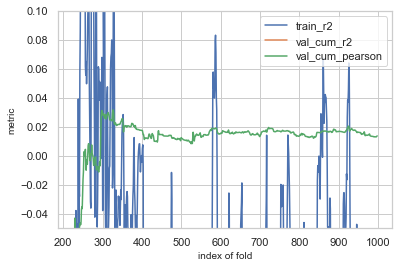

In [148]:
# lr=1e-2, StepLR step100, endlr=4e-12 nepoch=4, trainlook=16, evallook=8, hidden=128 Transformer
# Feature embedding!
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -2.0935e-01
The ending score for metric val_cum_r2 is: -4.7548e-01
The ending score for metric val_cum_pearson is: 2.9045e-03


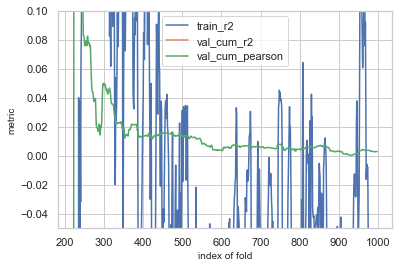

In [146]:
# lr=1e-2, StepLR step200, endlr=3e-7 nepoch=4, trainlook=16, evallook=4, hidden=128 Transformer
# Feature embedding!
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -2.0469e-02
The ending score for metric val_cum_r2 is: -1.3575e-01
The ending score for metric val_cum_pearson is: 1.3348e-02


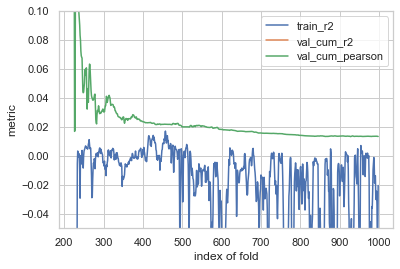

In [186]:
# lr=1e-2, StepLR step100, endlr=9e-12 nepoch=8, trainlook=16, evallook=8, hidden=256 Transformer
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -6.2771e-02
The ending score for metric val_cum_r2 is: -1.1585e-01
The ending score for metric val_cum_pearson is: 3.2505e-02


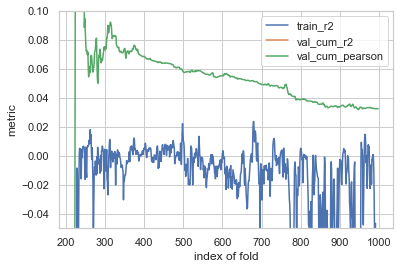

In [183]:
# lr=1e-2, StepLR step200, endlr=3e-7 nepoch=4, trainlook=16, evallook=4, hidden=128 Transformer
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

### Convolution Results
So bad not even want to see the plot

### LSTM Results

The ending score for metric train_r2 is: -2.7098e-02
The ending score for metric val_cum_r2 is: -3.1839e-02
The ending score for metric val_cum_pearson is: 1.4905e-02


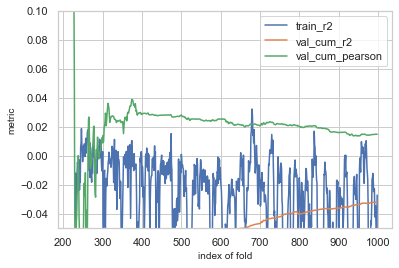

In [139]:
# lr=1e-2, StepLR step100, nepoch=4, trainlook=16, evallook=8, hidden=128 LSTM
# Same setting different results...
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -3.6356e-02
The ending score for metric val_cum_r2 is: -2.9426e-02
The ending score for metric val_cum_pearson is: 1.7145e-02


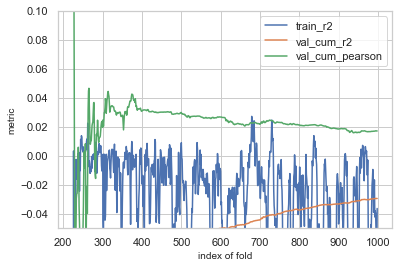

In [137]:
# lr=1e-2, StepLR step100, nepoch=4, trainlook=16, evallook=8, hidden=128 LSTM
# Same setting different results...
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -3.2474e-02
The ending score for metric val_cum_r2 is: -2.8124e-02
The ending score for metric val_cum_pearson is: 3.6343e-02


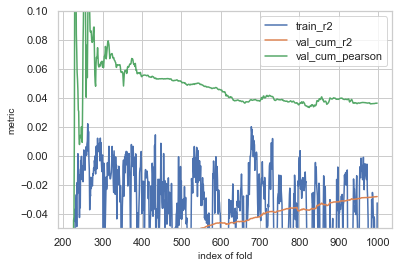

In [134]:
# lr=1e-2, StepLR step100, nepoch=4, trainlook=16, evallook=8, hidden=128 LSTM
# Same setting different results...
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

In [ ]:
model_path = '../../model/dump/LSTM_1for54_Feb25'
torch.save(net.state_dict(), model_path)



The ending score for metric train_r2 is: -4.7940e-02
The ending score for metric val_cum_r2 is: -4.0297e-02
The ending score for metric val_cum_pearson is: 1.2276e-02


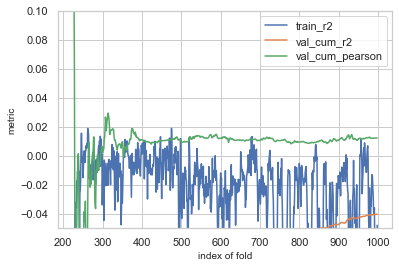

In [130]:
# lr=1e-2, StepLR step200, nepoch=4, trainlook=16, evallook=8, hidden=128 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -1.9403e-02
The ending score for metric val_cum_r2 is: -3.5612e-02
The ending score for metric val_cum_pearson is: -1.7057e-03


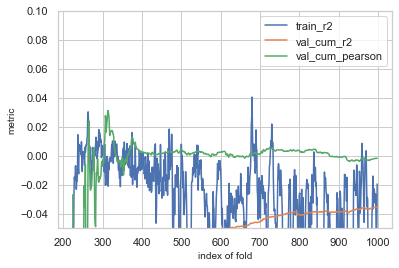

In [128]:
# lr=1e-2, StepLR step200, nepoch=8, trainlook=16, evallook=8, hidden=128 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -5.1776e-02
The ending score for metric val_cum_r2 is: -2.3967e-01
The ending score for metric val_cum_pearson is: -4.9931e-02


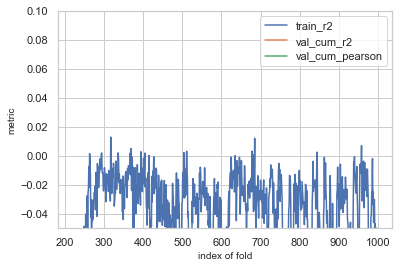

In [146]:
# lr=1e-2, StepLR step200, nepoch=4, trainlook=16, evallook=4, hidden=1024 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -1.4977e-01
The ending score for metric val_cum_r2 is: -2.9184e-01
The ending score for metric val_cum_pearson is: 2.0619e-02


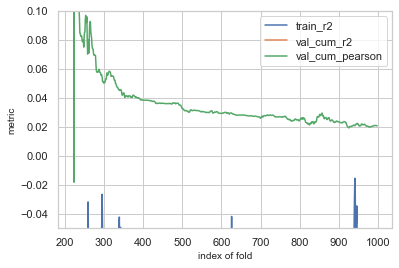

In [126]:
# lr=1e-2, StepLR step200, nepoch=4, trainlook=16, evallook=4, hidden=1024 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -4.0054e-02
The ending score for metric val_cum_r2 is: -2.8844e-02
The ending score for metric val_cum_pearson is: 1.8542e-02


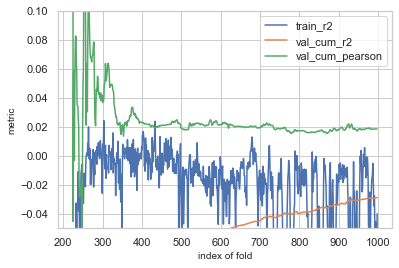

In [121]:
# lr=1e-2, StepLR step100, nepoch=4, trainlook=16, evallook=8, hidden=64 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 1.5655e-02
The ending score for metric val_cum_r2 is: -4.8137e-02
The ending score for metric val_cum_pearson is: -1.4524e-02


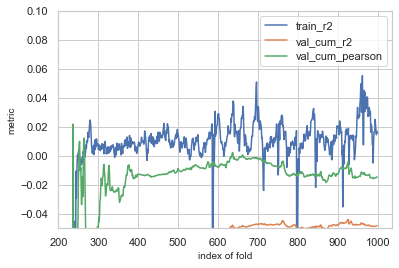

In [118]:
# lr=5e-3, cyclicLR, nepoch=4, trainlook=32, evallook=4, hidden=256 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 4.3607e-02
The ending score for metric val_cum_r2 is: -6.8243e-02
The ending score for metric val_cum_pearson is: -1.4100e-03


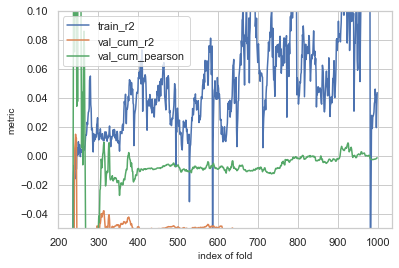

In [116]:
# lr=5e-3, cyclicLR, nepoch=8, trainlook=32, evallook=4, hidden=256 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 2.0726e-01
The ending score for metric val_cum_r2 is: -1.0386e-01
The ending score for metric val_cum_pearson is: -1.4415e-02


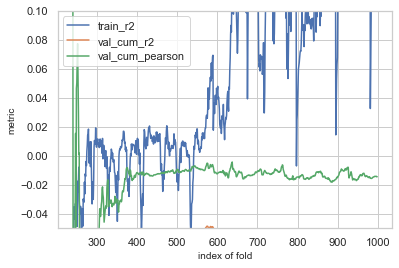

In [113]:
# lr=5e-3, cyclicLR, nepoch=8, trainlook=32, evallook=8, hidden=128 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: -1.4669e-02
The ending score for metric val_cum_r2 is: -7.8121e-02
The ending score for metric val_cum_pearson is: -1.2375e-02


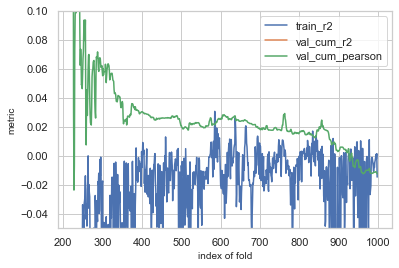

In [93]:
# lr=5e-3, cyclicLR, nepoch=2, trainlook=16, evallook=8, hidden=64 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 1.1000e-02
The ending score for metric val_cum_r2 is: -1.0730e-01
The ending score for metric val_cum_pearson is: -2.9663e-03


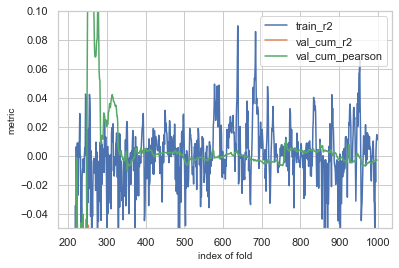

In [95]:
# lr=5e-3, cyclicLR, nepoch=4, trainlook=8, evallook=4, hidden=128 LSTM
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

### MLP results

The ending score for metric train_r2 is: 3.8741e-02
The ending score for metric val_cum_r2 is: -2.9150e-01
The ending score for metric val_cum_pearson is: -4.7151e-03


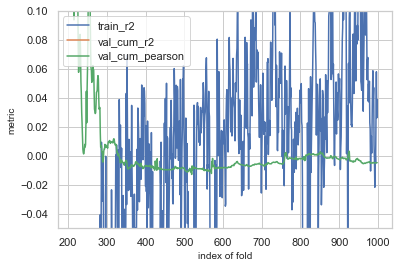

In [100]:
# lr=5e-3, cylicLR, nepoch=4, trainlook=8, evallook=4 MLP
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 3.8486e-01
The ending score for metric val_cum_r2 is: -4.6707e-01
The ending score for metric val_cum_pearson is: -6.1139e-03


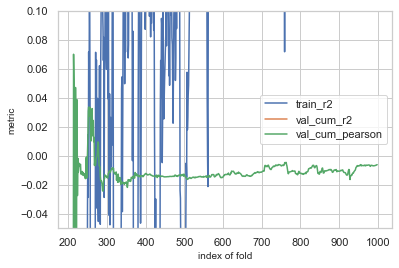

In [102]:
# lr=5e-3, cylicLR, nepoch=8, trainlook=8, evallook=4 MLP
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 3.5985e-01
The ending score for metric val_cum_r2 is: -4.6350e-01
The ending score for metric val_cum_pearson is: -1.9640e-02


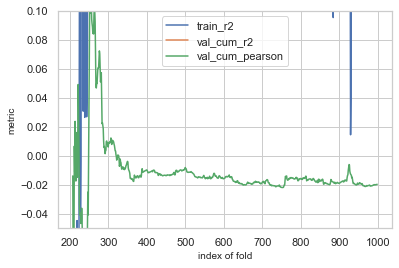

In [104]:
# lr=5e-3, cylicLR, nepoch=16, trainlook=4, evallook=4 MLP
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()
## Overfit!

The ending score for metric train_r2 is: 2.6602e-01
The ending score for metric val_cum_r2 is: -2.3675e-01
The ending score for metric val_cum_pearson is: -3.4021e-03


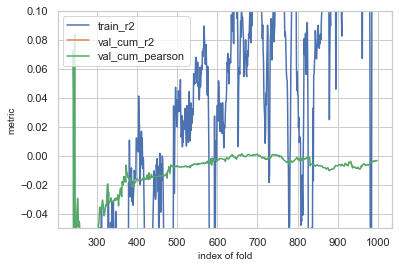

In [107]:
# lr=5e-3, cylicLR, nepoch=4, trainlook=32, evallook=8 MLP
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 7.2027e-01
The ending score for metric val_cum_r2 is: -6.5608e-01
The ending score for metric val_cum_pearson is: -9.1098e-03


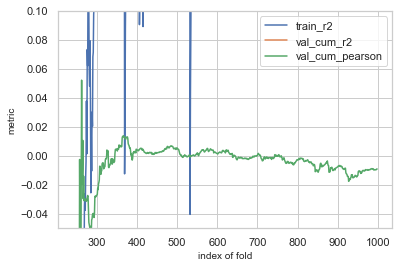

In [110]:
# lr=5e-3, cylicLR, nepoch=8, trainlook=32, evallook=8 MLP feature space 1024
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

In [47]:
ds_day = ds.drop_dims('timeslot')

In [58]:
ds_test = ds.copy()

In [59]:
ds_test['day'] = ds_test['day']

In [73]:
ds_test = ds_test.assign(day_feature=('day', ds_test['day'].data))
ds_test = ds_test.assign(asset_name=('asset', ds_test['asset'].data))

In [74]:
ds_test

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/24)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    open_0             (day, asset) float64 ...
    high_0             (day, asset) float64 ...
    low_0              (day, asset) float64 ...
    return_0           (day, asset) float64 ...
    day_feature        (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
    asset_name         (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53

In [56]:
y_train_true = ds['return'].sel(day=[207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222])

In [60]:
y_train_true.coords

Coordinates:
  * day      (day) int32 207 208 209 210 211 212 213 ... 217 218 219 220 221 222
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53

## Evaluation

### Setup

In [12]:
# check dataset again
ds

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/22)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    mean_volume        (day, asset) float64 ...
    close_0            (day, asset) float64 ...
    open_0             (day, asset) float64 ...
    high_0             (day, asset) float64 ...
    low_0              (day, asset) float64 ...
    return_0           (day, asset) float64 ...

In [14]:
ds_eval = ds.drop_dims('timeslot')

In [202]:
ds_eval

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables: (12/16)
    turnoverRatio      (day, asset) float64 ...
    transactionAmount  (day, asset) float64 ...
    pe_ttm             (day, asset) float64 ...
    pe                 (day, asset) float64 ...
    pb                 (day, asset) float64 ...
    ps                 (day, asset) float64 ...
    ...                 ...
    mean_volume        (day, asset) float64 ...
    close_0            (day, asset) float64 ...
    open_0             (day, asset) float64 ...
    high_0             (day, asset) float64 ...
    low_0              (day, asset) float64 ...
    return_0           (day, asset) float64 ...

In [53]:
train_lookback = 16
eval_lookback = 4
# model_path = '../../model/dump/GoodModel/LSTM_1for54_Feb25'
model_path = '../../model/dump/GoodModel/2023-02-26_Transformer_1'
feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']
prerpocess = MinMaxScaler()

model = NN_wrapper(preprocess=prerpocess, lr=1e-3, lrstep=100, train_lookback=train_lookback,
                   per_eval_lookback=eval_lookback, n_epoch=4, hidden_size=128, feature_name=feature, n_asset=54,
                   network='Transformer', is_eval=True, load_model_path=model_path)

performance = evaluation_for_submission(model, given_ds=ds, qids=qids, lookback_window=train_lookback,
                                        per_eval_lookback=eval_lookback, option=None)




  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: -6.9619e-03
The ending score for metric test_cum_r2 is: -4.2847e-02
The ending score for metric test_cum_pearson is: -3.4853e-02


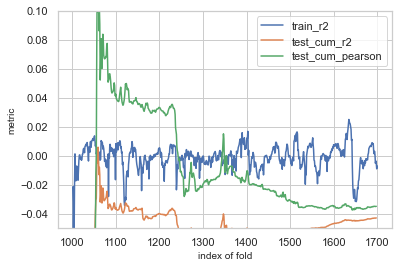

In [54]:
# test Transformer; lr1e-4, trainL 16, evalL 8, nepoch 4, hidden 128
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.show()

The ending score for metric train_r2 is: -2.3233e-03
The ending score for metric test_cum_r2 is: -1.3946e-02
The ending score for metric test_cum_pearson is: 3.8758e-03


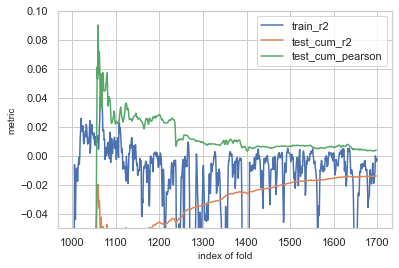

In [28]:
# test LSTM; StepLR100, lr5e-3, trainL 16, evalL 8, nepoch 4, hidden 128
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.show()

The ending score for metric train_r2 is: -2.5150e-02
The ending score for metric test_cum_r2 is: -1.6342e-02
The ending score for metric test_cum_pearson is: 1.6008e-02


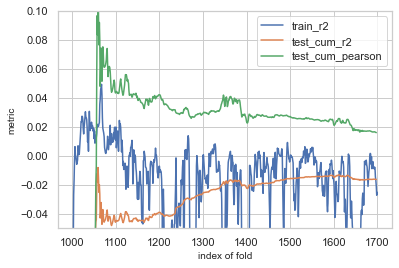

In [23]:
# test LSTM; StepLR100, lr5e-3, trainL 16, evalL 8, nepoch 4, hidden 128
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.show()

The ending score for metric train_r2 is: -2.0220e-02
The ending score for metric test_cum_r2 is: -2.0311e-02
The ending score for metric test_cum_pearson is: 3.3914e-03


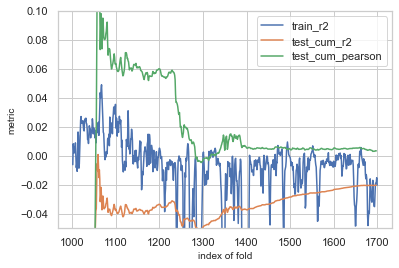

In [26]:
# test LSTM; StepLR200, lr1e-3, trainL 16, evalL 8, nepoch 4, hidden 128
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.show()